<a href="https://colab.research.google.com/github/ben-wycliff/cv-exam/blob/main/ORB_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# unzip dataset version 3
!unzip -q "/content/drive/MyDrive/CVExam/dataset.zip"

In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from PIL import Image
from skimage import io, feature

# Helpers

In [4]:
def plot_bar_chart(data):
    """
    Plot a bar chart given a dictionary of keys (x-axis) and values (y-axis).

    Arguments:
    data -- dictionary of keys and values

    Example:
    data = {'A': 10, 'B': 20, 'C': 15}
    plot_bar_chart(data)
    """
    keys = data.keys()
    values = data.values()

    plt.bar(keys, values)
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.title('Bar Chart')
    plt.show()

def get_image_size(image_path):
    """
    Read an image and return its size.

    Arguments:
    image_path -- path to the image file

    Returns:
    A tuple containing the width and height of the image

    Example:
    image_path = 'image.jpg'
    size = get_image_size(image_path)
    print(size)  # Output: (640, 480)
    """
    image = Image.open(image_path)
    width, height = image.size
    return width, height

def plot_confusion_matrix(y_test, y_pred, labels, figsize=(8, 8)):
  """
    y_test: true y labels
    y_pred: predicted y labels
    labels: class labels
  """
  disp = ConfusionMatrixDisplay.from_predictions(y_test,
                                                 y_pred,
                                                 display_labels=labels,
                                                 cmap="Blues",
                                                 normalize='true')
  fig = disp.figure_
  fig.set_figwidth(figsize[1])
  fig.set_figheight(figsize[0])


def plot_image_grid(images, titles):
    """
    Plots a grid of four images with titles.

    Args:
        images (list): A list of four images (as arrays or paths).
        titles (list): A list of four titles corresponding to the images.
    """
    fig, axs = plt.subplots(2, 2)
    fig.tight_layout(pad=0.5)

    for i, ax in enumerate(axs.flat):
        # Load and display the image
        if isinstance(images[i], str):  # Image path provided
            image = plt.imread(images[i])
        else:  # Image array provided
            image = images[i]
        ax.imshow(image)
        ax.axis('off')

        # Add the title
        ax.set_title(titles[i])

    plt.show()


def plot_color_histogram_grid(images, names, bins=8):
    """
    Plots a grid of color histograms for multiple images with specified number of bins.

    Args:
        images (list): A list of images (as file paths).
        names (list): A list of image names.
        bins (int): Number of bins for the histogram (default: 8).
    """
    num_images = len(images)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))

    fig, axs = plt.subplots(rows, cols, figsize=(8, 6))
    fig.tight_layout(pad=1.5)

    for i, ax in enumerate(axs.flat):
        if i < num_images:
            # Read the image
            image_path = images[i]
            # Read the image
            image = cv2.imread(image_path)

            # Convert the image from BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Separate color channels
            red_channel = image_rgb[:, :, 0]
            green_channel = image_rgb[:, :, 1]
            blue_channel = image_rgb[:, :, 2]

            # Calculate the histograms for each color channel
            red_hist = cv2.calcHist([red_channel], [0], None, [bins], [0, 256])
            green_hist = cv2.calcHist([green_channel], [0], None, [bins], [0, 256])
            blue_hist = cv2.calcHist([blue_channel], [0], None, [bins], [0, 256])

            # Plot the histograms for each color channel as line plots
            bin_centers = np.arange(bins)
            ax.plot(bin_centers, red_hist, color='red', label='Red Channel')
            ax.plot(bin_centers, green_hist, color='green', label='Green Channel')
            ax.plot(bin_centers, blue_hist, color='blue', label='Blue Channel')

            # Set the image name as the title
            ax.set_title(names[i])

            # Set the labels and title for the grid
            if i >= (rows - 1) * cols:
                ax.set_xlabel('Bins')
            if i % cols == 0:
                ax.set_ylabel('Normalized Frequency')

            # Add a legend to the plot
            ax.legend()
        else:
            # Remove empty subplots if the number of images is not a perfect square
            fig.delaxes(ax)

    # Show the plot
    plt.show()

def plot_images_with_keypoints(images, image_names):
    fig, axes = plt.subplots(2, 2, figsize=(7, 7))
    axes = axes.ravel()

    orb = cv2.ORB_create(nfeatures=40)

    for i, img_path in enumerate(images):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (400, 400))

        # Detect ORB keypoints and compute descriptors
        keypoints, _ = orb.detectAndCompute(img, None)

        # Draw keypoints on the image
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Plot the image with keypoints
        axes[i].imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        axes[i].set_title(image_names[i])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load data

In [5]:
images = glob("./data/train/*/*", recursive=True) +\
         glob("./data/val/*/*", recursive=True) +\
         glob("./data/test/*/*", recursive=True)

In [6]:
# sample image preview
sample_images = [glob("./data/train/cassava/*", recursive=True)[0],
                 glob("./data/train/grass/*", recursive=True)[0],
                 glob("./data/train/maize/*", recursive=True)[0],
                 glob("./data/train/sugarcane/*", recursive=True)[0]]

sample_images_names = ["cassava", "grass", "maize", "sugarcane"]

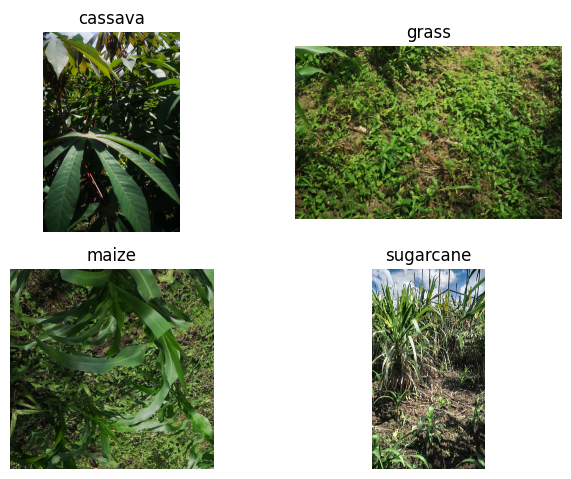

In [7]:
plot_image_grid(sample_images, sample_images_names)

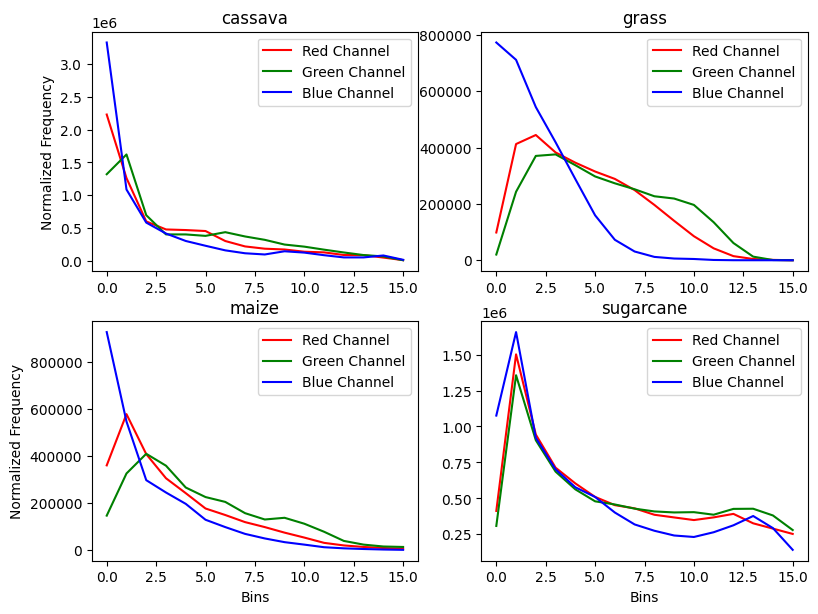

In [8]:
# Image color histograms
plot_color_histogram_grid(sample_images, sample_images_names, bins=16)

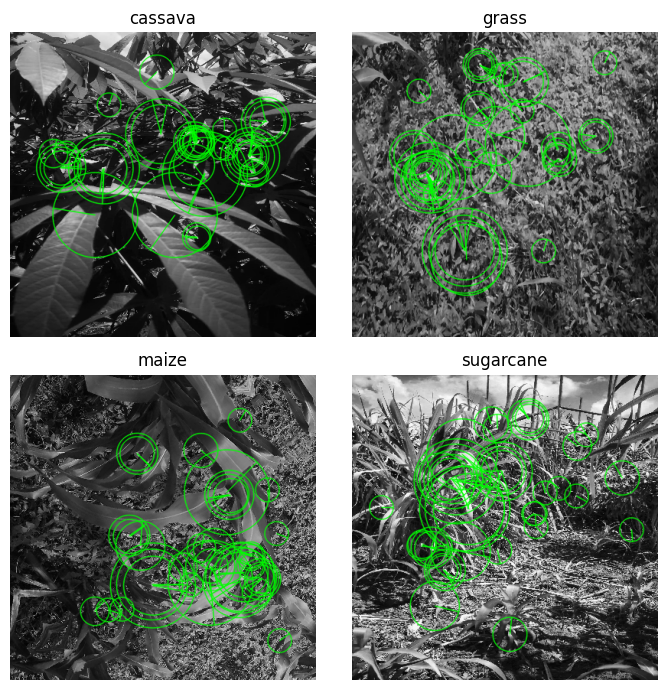

In [9]:
# image orb descriptors
plot_images_with_keypoints(sample_images, sample_images_names)

# Test Sobel Image outputs

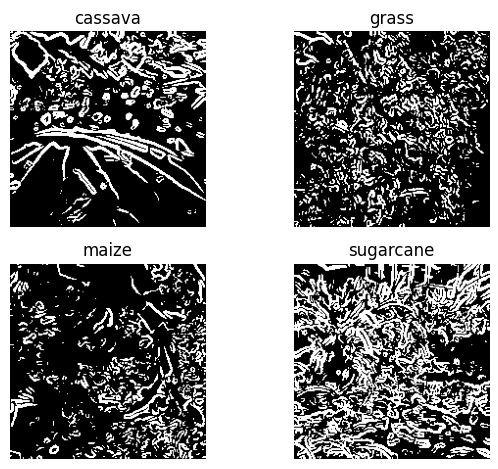

In [10]:
width = 200
height = 200

def read_img_edged(path):
    gray_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    gray_image = cv2.resize(gray_image, (width, height))
    gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)


    # Apply the Sobel Operator
    gradient_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
    # Calculate gradient magnitude
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)

    threshold = 120
    thresholded_image = np.where(gradient_magnitude > threshold, 255, 0).astype(np.uint8)
    return thresholded_image


def original_image(image_path):
    gray_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return cv2.resize(gray_image, (width, height))

def plot_images(image_paths, titles):
    fig, axes = plt.subplots(2,2)
    for i, ax in enumerate(axes.flat):
        # Load the image
        image_path = image_paths[i]
        image = read_img_edged(image_path)
#         image = original_image(image_path)
        # Plot the image
        ax.imshow(image, cmap="gray")
        ax.set_title(titles[i])
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show();



# sample_paths = random.sample(images, 3)


plot_images(sample_images, sample_images_names)


# SIFT feature extraction

In [46]:
# Extract SIFT features
image = read_img_edged(images[0])
sift = cv2.SIFT_create()
keypoints_sift, descriptors_sift = sift.detectAndCompute(image, None)

orb = cv2.ORB_create(nfeatures=20)
keypoints, descriptors_orb = orb.detectAndCompute(image, None)

In [47]:
for k in range(1):
    print("ORB feature: ", descriptors_orb.flatten().shape)
    print("SIFT feature: ", descriptors_sift.flatten().shape)
    print("Features: ", list(descriptors_orb[k])+list(descriptors_sift[k]))


ORB feature:  (608,)
SIFT feature:  (161408,)
Features:  [8, 249, 190, 243, 149, 198, 183, 180, 198, 81, 202, 5, 156, 189, 96, 66, 197, 127, 185, 211, 219, 169, 154, 229, 233, 181, 158, 64, 200, 26, 181, 26, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 4.0, 5.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 15.0, 30.0, 4.0, 1.0, 56.0, 2.0, 0.0, 0.0, 1.0, 10.0, 1.0, 17.0, 150.0, 29.0, 0.0, 0.0, 3.0, 7.0, 2.0, 32.0, 71.0, 12.0, 3.0, 1.0, 21.0, 69.0, 22.0, 28.0, 3.0, 4.0, 12.0, 6.0, 37.0, 150.0, 79.0, 12.0, 92.0, 0.0, 0.0, 0.0, 8.0, 109.0, 10.0, 38.0, 150.0, 95.0, 1.0, 0.0, 0.0, 2.0, 1.0, 66.0, 77.0, 127.0, 13.0, 12.0, 52.0, 21.0, 6.0, 9.0, 1.0, 8.0, 79.0, 89.0, 68.0, 39.0, 16.0, 1.0, 45.0, 9.0, 1.0, 11.0, 79.0, 127.0, 6.0, 10.0, 150.0, 72.0, 1.0, 2.0, 4.0, 3.0, 2.0, 35.0, 109.0, 37.0, 4.0, 25.0, 31.0, 2.0, 0.0, 22.0, 1.0, 1.0, 4.0, 63.0, 111.0, 35.0, 1.0, 0.0]


In [68]:
def extract_features1(image_paths): # for ORB
    # Create ORB object
    orb = cv2.ORB_create()

    # Create SIFT object
    # sift = cv2.SIFT_create(nfeatures=20)

    # Lists to store the feature vectors and image names
    feature_vectors = []
    image_names = []

    for image_path in image_paths:
        # Read the image
        image = read_img_edged(image_path)


        # Detect keypoints and compute descriptors using ORB
        keypoints, descriptors = orb.detectAndCompute(image, None)

        # Detect keypoints and compute descriptors using SIFT
        # keypoints_sift, descriptors = sift.detectAndCompute(image, None)

        # Append the feature vector and image name to the lists
        feature_vectors.append(descriptors.flatten())
        image_names.append(image_path)

    # Create a dataframe with feature vectors
    df = pd.DataFrame(feature_vectors)

    # Add column names for feature elements
    df.columns = ['Feature_{}'.format(i) for i in range(df.shape[1])]

    # Add column for image names
    df.insert(0, 'ImageName', image_names)


    return df

def extract_features2(image_paths, bins=8): # for color histograms
    feature_vectors = []
    image_names = []

    for image_path in image_paths:
        # Read the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Calculate histogram for each channel
        hist = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 180, 0, 256, 0, 256])

        # Normalize histogram to ensure consistent feature scale
        hist = cv2.normalize(hist, hist)

        # Flatten the histogram into a 1D feature vector
        hist = hist.flatten()

        # Append the feature vector and image name to the lists
        feature_vectors.append(hist)
        image_names.append(image_path)

    # Create a dataframe with feature vectors
    df = pd.DataFrame(feature_vectors)

    # Add column names for feature elements
    df.columns = ['Feature_{}'.format(i) for i in range(df.shape[1])]

    # Add column for image names
    df.insert(0, 'ImageName', image_names)

    return df

def extract_features3(image_paths): # for SIFT
    # Create SIFT object
    sift = cv2.SIFT_create(nfeatures=40)

    # Lists to store the feature vectors and image names
    feature_vectors = []
    image_names = []

    for image_path in image_paths:
        # Read the image
        image = original_image(image_path)

        # Detect keypoints and compute descriptors using SIFT
        keypoints_sift, descriptors = sift.detectAndCompute(image, None)

        # Append the feature vector and image name to the lists
        feature_vectors.append(descriptors.flatten())
        image_names.append(image_path)

    # Create a dataframe with feature vectors
    df = pd.DataFrame(feature_vectors)

    # Add column names for feature elements
    df.columns = ['Feature_{}'.format(i) for i in range(df.shape[1])]

    # Add column for image names
    df.insert(0, 'ImageName', image_names)


    return df

## Classification Using Color Histograms

In [18]:
# Create a dataframe from the descriptors
df = extract_features2(images)

In [19]:
df.head()

,ImageName,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_502,Feature_503,Feature_504,Feature_505,Feature_506,Feature_507,Feature_508,Feature_509,Feature_510,Feature_511
0,./data/train/sugarcane/sugarcane (55)_augmente...,0.090434,0.005048,0.004631,0.006591,0.010655,0.015270,0.018827,0.041416,0.072156,...,0.0,0.0,0.000239,2.264896e-06,0.0,0.0,0.0,0.0,0.0,0.0
1,./data/train/sugarcane/sugarcane (99).jpg,0.000242,0.000423,0.000166,0.000189,0.000362,0.001208,0.006547,0.009190,0.000053,...,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
2,./data/train/sugarcane/sugarcane (54)_augmente...,0.895870,0.001990,0.004101,0.005223,0.011268,0.001129,0.000000,0.000000,0.001955,...,0.0,0.0,0.007731,8.255496e-07,0.0,0.0,0.0,0.0,0.0,0.0
3,./data/train/sugarcane/sugarcane (57)_augmente...,0.006134,0.263717,0.034582,0.027223,0.033651,0.038053,0.031340,0.042158,0.001060,...,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0
4,./data/train/sugarcane/sugarcane (50)_augmente...,0.083934,0.010075,0.007341,0.009768,0.014337,0.018872,0.019703,0.033993,0.061915,...,0.0,0.0,0.000077,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df.fillna(0, inplace=True)

In [21]:
df.shape

(2332, 513)

In [22]:
df.describe()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_502,Feature_503,Feature_504,Feature_505,Feature_506,Feature_507,Feature_508,Feature_509,Feature_510,Feature_511
count,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,...,2.332000e+03,2.332000e+03,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2.332000e+03,2.332000e+03,2332.0
mean,0.070234,0.004108,0.002398,0.002283,0.002802,0.003777,0.005142,0.014433,0.003790,0.008392,...,9.346432e-07,5.941930e-08,0.000871,0.000078,0.000042,0.000011,0.000002,2.015707e-07,5.109497e-09,0.0
std,0.190897,0.023420,0.005845,0.003637,0.004315,0.005554,0.007405,0.053273,0.008284,0.014792,...,9.754282e-06,1.540504e-06,0.002464,0.000231,0.000121,0.000043,0.000011,2.606573e-06,1.387598e-07,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
25%,0.000424,0.000175,0.000288,0.000370,0.000469,0.000632,0.000795,0.000651,0.000201,0.001363,...,0.000000e+00,0.000000e+00,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
50%,0.001923,0.000788,0.000798,0.000927,0.001097,0.001534,0.002305,0.002967,0.000823,0.003389,...,0.000000e+00,0.000000e+00,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
75%,0.016451,0.002198,0.002223,0.002660,0.003592,0.004877,0.006813,0.009719,0.002953,0.007686,...,0.000000e+00,0.000000e+00,0.000264,0.000017,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
max,0.981219,0.884571,0.119445,0.038631,0.040966,0.054983,0.109264,0.869324,0.074654,0.142094,...,2.165451e-04,6.402310e-05,0.023479,0.003401,0.001535,0.000939,0.000253,7.569881e-05,5.189222e-06,0.0


In [23]:
def determine_label(name):
    if "sugarcane" in name:
        return 0
    elif "cassava" in name:
        return 1
    elif "maize" in name:
        return 2
    else:
        return 3
df["label"] = df.ImageName.apply(determine_label)

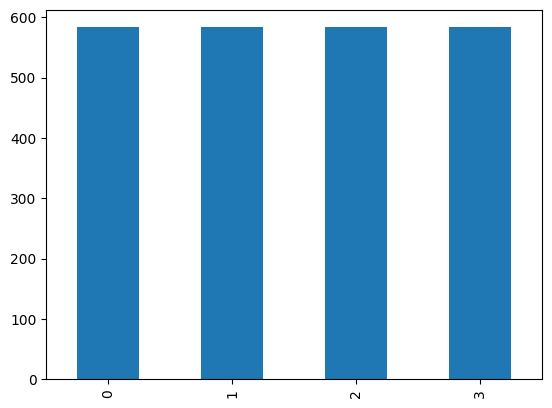

In [24]:
df.label.value_counts().plot(kind="bar");

In [25]:
def train_and_evaluate_classifier(df, labels_column, k=3):
    # Get the feature columns by selecting columns with 'feature' or 'pixel' in their names
    feature_columns = df.columns[df.columns.str.contains('Feature|Pixel')].tolist()

    # Select the feature columns and the labels column
    X = df[feature_columns]
    y = df[labels_column]

    # Impute missing values with the mean of each feature
    imputer = SimpleImputer()
    X_imputed = imputer.fit_transform(X)

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # X_test = df_test[feature_columns]
    # y_test = df_test[labels_column]
    # X_test = scaler.fit_transform(X_test)

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Train the KNN classifier
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)
    y_train_pred = classifier.predict(X_train)

    print("test: ", len(y_test), " pred: ", len(y_pred))
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print("Test accuracy: ", accuracy)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print("Train accuracy: ", train_accuracy)

    confusion = confusion_matrix(y_train, y_train_pred)
    report = classification_report(y_test, y_pred)

    return confusion, report, y_test, y_pred

# Example usage:
# Assuming you have a dataframe named 'df' with the required columns
labels_column = 'label'
confusion, report, y_test, y_pred = train_and_evaluate_classifier(df, labels_column)


print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

test:  700  pred:  700
Test accuracy:  0.94
Train accuracy:  0.9712009803921569
Confusion Matrix:
[[393   0   2   1]
 [ 11 392   6   3]
 [  4   2 399  16]
 [  1   0   1 401]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       187
           1       0.98      0.94      0.96       171
           2       0.95      0.87      0.91       162
           3       0.92      0.97      0.94       180

    accuracy                           0.94       700
   macro avg       0.94      0.94      0.94       700
weighted avg       0.94      0.94      0.94       700



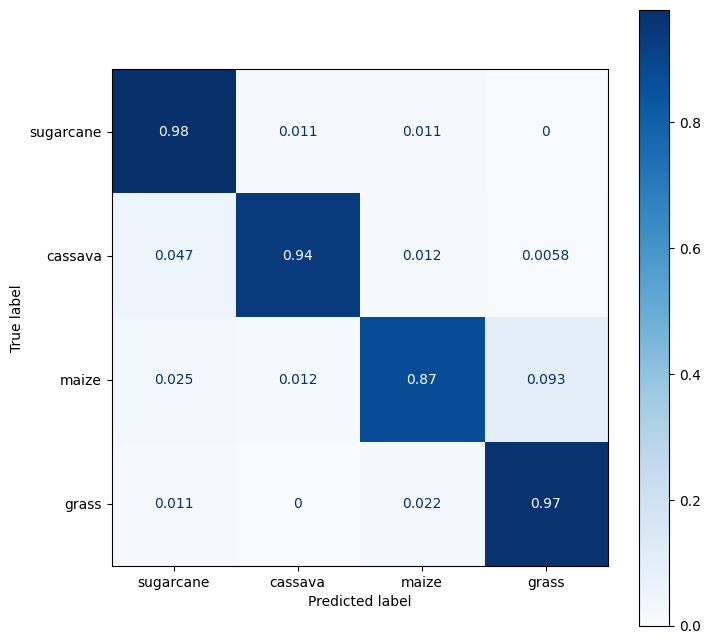

In [26]:
labels = ["sugarcane", "cassava", "maize", "grass"]
plot_confusion_matrix(y_test, y_pred, labels)

## Classification using ORB + GaussianBlur + Sobel

In [27]:
df2 = extract_features1(images)

In [28]:
df2.fillna(0, inplace=True)
df2["label"] = df2.ImageName.apply(determine_label)

In [51]:
# Assuming you have a dataframe named 'df' with the required columns
labels_column = 'label'
confusion, report, y_test, y_pred = train_and_evaluate_classifier(df2, labels_column, 3)


print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

test:  700  pred:  700
Test accuracy:  0.39571428571428574
Train accuracy:  0.6691176470588235
Confusion Matrix:
[[335  16  23  22]
 [114 227  28  43]
 [108  54 229  30]
 [ 56  28  18 301]]
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.53      0.44       187
           1       0.40      0.29      0.33       171
           2       0.39      0.31      0.35       162
           3       0.44      0.43      0.43       180

    accuracy                           0.40       700
   macro avg       0.40      0.39      0.39       700
weighted avg       0.40      0.40      0.39       700



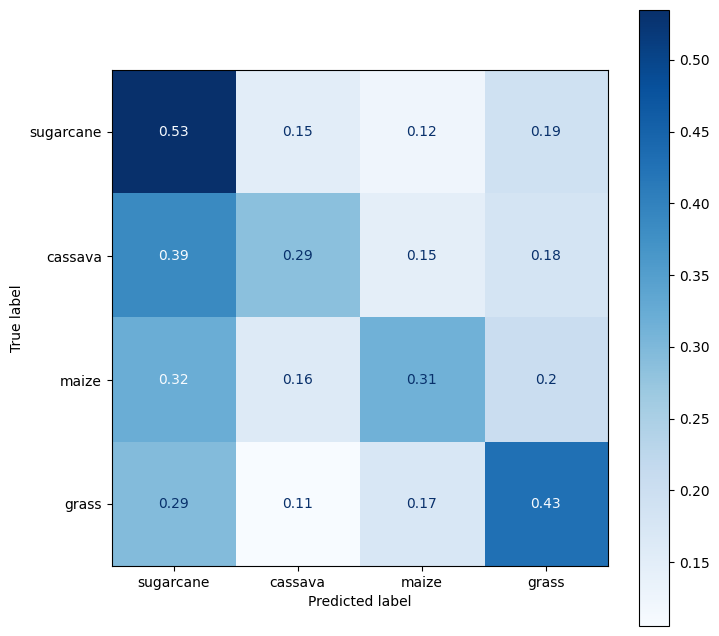

In [52]:
labels = ["sugarcane", "cassava", "maize", "grass"]
plot_confusion_matrix(y_test, y_pred, labels)

# Classification Using SIFT

In [69]:
df3 = extract_features3(images)

In [70]:
df3.fillna(0, inplace=True)
df3["label"] = df3.ImageName.apply(determine_label)

In [72]:
# Assuming you have a dataframe named 'df' with the required columns
labels_column = 'label'
confusion, report, y_test, y_pred = train_and_evaluate_classifier(df3, labels_column, 3)


print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)

test:  700  pred:  700
Test accuracy:  0.3985714285714286
Train accuracy:  0.4638480392156863
Confusion Matrix:
[[395   0   0   1]
 [313  99   0   0]
 [379   7  19  16]
 [156   3   0 244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.98      0.48       187
           1       0.53      0.06      0.11       171
           2       0.00      0.00      0.00       162
           3       0.90      0.48      0.62       180

    accuracy                           0.40       700
   macro avg       0.43      0.38      0.30       700
weighted avg       0.44      0.40      0.31       700



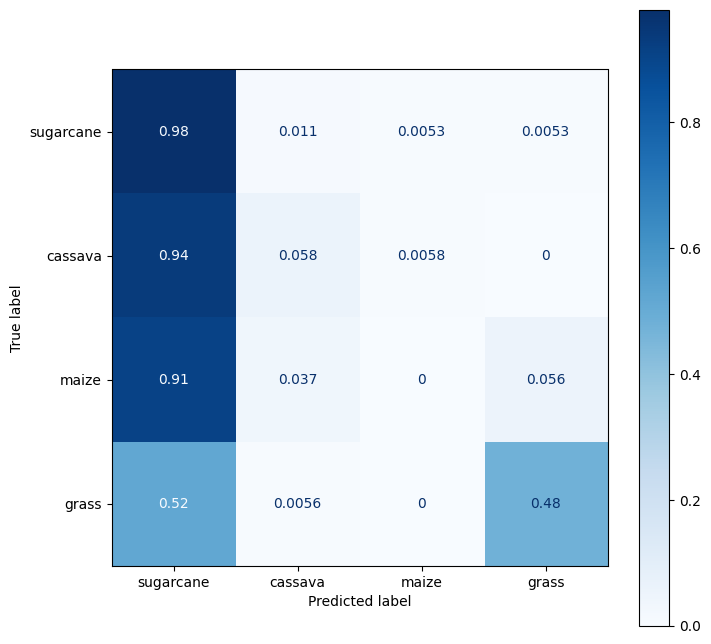

In [73]:
labels = ["sugarcane", "cassava", "maize", "grass"]
plot_confusion_matrix(y_test, y_pred, labels)